This script is to read the train images from BSDS and create patches and events out of it.

In [1]:
import cv2
import os
from sklearn.feature_extraction import image as image_extractor
from scipy import ndimage
import numpy as np
import warnings
import time
from skimage import io
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
images = []
images_xgradient = []
images_ygradient = []
folder = "train/"
width = 240
height = 180
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),0)
    if img is not None:
        img = cv2.resize(img,(width,height))
        img_xgradient = ndimage.sobel(img, axis=0).astype('float32')
        img_ygradient = ndimage.sobel(img, axis=1).astype('float32')
        
        images.append(img.astype('float32'))
        images_xgradient.append(img_xgradient)
        images_ygradient.append(img_ygradient)

In [3]:
num_images = len(images)
num_images

200

In [4]:
images[0].shape

(180, 240)

In [5]:
num_patches = 100000
patches_per_image = int(num_patches/num_images)
patches_per_image

500

Extracting patches from the images

In [6]:
image_patches_x = []
image_patches_y = []
# total_data = np.zeros((num_patches,2*patch_size[0]*patch_size[1] + 2*patch_size[0]*patch_size[1]*num_frame))
C_scale = 100.
patch_size = (5,5)
num_frame = 5

In [7]:
x_input = []
y_input = []
for index, (x_grad,y_grad) in enumerate(zip(images_xgradient,images_ygradient)):
    x_patches = image_extractor.extract_patches_2d(x_grad, patch_size, patches_per_image)
    x_patches = x_patches.reshape(x_patches.shape[0],(x_patches.shape[1]*x_patches.shape[2])).T
    #x_input.append(x_patches.T)
    
    if index == 0:
        input_data_x = x_patches
    else:
        input_data_x = np.hstack((input_data_x,x_patches))
        
    
    y_patches = image_extractor.extract_patches_2d(y_grad, patch_size, patches_per_image)
    y_patches = y_patches.reshape(y_patches.shape[0],(y_patches.shape[1]*y_patches.shape[2])).T
    #y_input.append(y_patches.T)

    if index == 0:
        input_data_y = y_patches
    else:
        input_data_y = np.hstack((input_data_y,y_patches))
        
input_data = np.vstack((input_data_x,input_data_y))
input_data.shape

(50, 100000)

In [8]:
input_data

array([[187., 170.,  81., ..., 244.,  21.,   0.],
       [218., 217.,  71., ...,  29.,  22., 255.],
       [200., 255.,  51., ...,   7.,  30., 252.],
       ...,
       [ 10.,   8., 247., ...,   6.,   5.,  34.],
       [ 21., 238., 251., ...,   6.,   6.,  40.],
       [  4.,  48.,   4., ...,   8.,   7., 242.]], dtype=float32)

In [9]:
np.isnan(input_data).any()

False

Create function for event creation

In [10]:
def event_simulation(threshold, num_frames,pixel_intensity):
    r = pixel_intensity
    Ep = np.zeros((num_frames))
    En = np.zeros((num_frames))
    for i in range(num_frames):
        if pixel_intensity > r:
            Ep[i] = np.floor(np.log((0.001 + pixel_intensity)/r) / np.log(threshold))
            r = threshold**Ep[i]*r
        else:
            En[i] = - np.ceil(np.log((0.001 + pixel_intensity)/r) / np.log(threshold))
            r = threshold**En[i]*r
    return Ep.T,En.T            

In [11]:
threshold = 1.28
image_matrix_initialised = False
for image in images:
    image_patches = image_extractor.extract_patches_2d(image, patch_size, patches_per_image)
    
    patch_matrix_initialised = False
    for patch_num in range(image_patches.shape[0]):
        pixel_matrix_initialized = False
        for i in range(image_patches.shape[1]):
            for j in range(image_patches.shape[2]):
                Ep, En = event_simulation(threshold,num_frame,image_patches[patch_num, i, j])
                if not pixel_matrix_initialized:
                    pixel_event_matrix = Ep
                    pixel_event_matrix = np.hstack((pixel_event_matrix,En))
                    pixel_matrix_initialized = True
                else:
                    temp = np.hstack((Ep,En))
                    pixel_event_matrix = np.hstack((pixel_event_matrix,temp))
        if not patch_matrix_initialised:
            patch_event_matrix = pixel_event_matrix
            patch_matrix_initialised = True
        else:
            patch_event_matrix = np.vstack((patch_event_matrix,pixel_event_matrix))
            
    if not image_matrix_initialised:
        event_matrix = patch_event_matrix
        image_matrix_initialised = True
    else:
        event_matrix = np.vstack((event_matrix,patch_event_matrix))
        
                
event_matrix.shape

(100000, 250)

In [12]:
np.isnan(event_matrix).any()

False

In [13]:
data_patches = np.vstack((input_data,event_matrix.T))
data_patches.shape


(300, 100000)

In [14]:
data_patches = data_patches.astype(np.int32)

In [15]:
data_patches.dtype

dtype('int32')

In [16]:
data_patches

array([[187, 170,  81, ..., 244,  21,   0],
       [218, 217,  71, ...,  29,  22, 255],
       [200, 255,  51, ...,   7,  30, 252],
       ...,
       [ -1,  -1,  -1, ...,  -1,  -1,  -1],
       [  0,   0,   0, ...,   0,   0,   0],
       [ -1,  -1,  -1, ...,  -1,  -1,  -1]])

In [17]:
data_patches = data_patches.T

In [18]:
data_patches

array([[187, 218, 200, ...,  -1,   0,  -1],
       [170, 217, 255, ...,  -1,   0,  -1],
       [ 81,  71,  51, ...,  -1,   0,  -1],
       ...,
       [244,  29,   7, ...,  -1,   0,  -1],
       [ 21,  22,  30, ...,  -1,   0,  -1],
       [  0, 255, 252, ...,  -1,   0,  -1]])

Learning 

In [19]:
n_components = 700
print('Learning the dictionary...')
dico = MiniBatchDictionaryLearning(n_components=n_components, alpha=1, n_iter=500)





Learning the dictionary...


In [20]:
data_patches

array([[187, 218, 200, ...,  -1,   0,  -1],
       [170, 217, 255, ...,  -1,   0,  -1],
       [ 81,  71,  51, ...,  -1,   0,  -1],
       ...,
       [244,  29,   7, ...,  -1,   0,  -1],
       [ 21,  22,  30, ...,  -1,   0,  -1],
       [  0, 255, 252, ...,  -1,   0,  -1]])

In [22]:
np.isnan(data_patches).any()

False

In [23]:
# Actual learning
start_time = time.time()
V = dico.fit(data_patches).components_
elapsed_time = time.time() - start_time
print('Elapsed time = %.2fs' % elapsed_time)
print(V.shape)

Elapsed time = 710.78s
(700, 300)


In [24]:
V_gradients = V[:,:50]
V_events = V[:,50:]

## Testing

In [43]:
image_test = io.imread("frame_00000561.png",as_gray=True).astype('float32')
img_test  = cv2.resize(image_test,(width,height))
test_xgradient = ndimage.sobel(image_test, axis=0).astype('float32')
test_ygradient = ndimage.sobel(image_test, axis=1).astype('float32')
assert img_test.shape[0] == height and img_test.shape[1] == width

In [49]:
threshold = 1.28
test_event_matrix = np.zeros((height,width,2*5))
for row in range(img_test.shape[0]):
    for col in range(img_test.shape[1]):
        Ep, En = event_simulation(threshold,num_frame,img_test[i,j])
        event_array = np.hstack((Ep,En))
        test_event_matrix[row,col,:] = event_array 
                
test_event_matrix.shape

(180, 240, 10)

In [50]:
test_event_patches = image_extractor.extract_patches_2d(test_event_matrix, patch_size)
test_event_patches.shape

(41536, 5, 5, 10)

In [52]:
data_test = test_event_patches.reshape(test_event_patches.shape[0], -1)
data_test.shape

(41536, 250)

In [55]:
n_coefs = 3
coder = SparseCoder(dictionary=V_events, transform_algorithm='omp', transform_n_nonzero_coefs=n_coefs)

In [56]:
np.transpose(data_test).shape

(250, 41536)

In [57]:
start_time = time.time()
code = coder.transform(data_test)
elapsed_time = time.time() - start_time
print('Elapsed time = %.2fs' % elapsed_time)

Elapsed time = 86.04s


In [58]:
code.shape

(41536, 700)

In [59]:
patches_g = np.dot(code, V_gradients)
patches_g.shape

(41536, 50)

In [60]:
patches_g = patches_g.reshape(patches_g.shape[0],patch_size[0],patch_size[1],2)
patches_g.shape

(41536, 5, 5, 2)

In [61]:
reconstruction = image_extractor.reconstruct_from_patches_2d(patches_g, (img_test.shape[0],img_test.shape[1],2))
reconstruction.shape

(180, 240, 2)

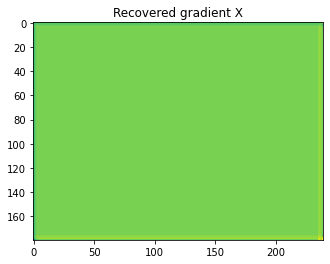

In [65]:
plt.imshow(reconstruction[:,:,0])
plt.title('Recovered gradient X')
plt.show()